# Figure 8 - 1D spectrum versus 3D spectra
This Jupyter notebooks reproduces Figure 8. The output .png and .pdf files are saved in <em>/figures</em>. 3D GCM phase-dependent spectra compared to the 1D retrieved posterior-mean spectrum demonstrate we are offset in absolute flux, but broadly consistent in terms of spectral line contrast of the water lines.

In [1]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from astropy.io import fits
import pickle
import matplotlib.gridspec as gridspec
from astropy.modeling import models
from astropy import units as u
from scipy import interpolate
from matplotlib import colormaps

Functions to load the GCM spectra.

In [2]:
class HayleyBeltzModel():
    def load_spectrum(fpath, trim=10):
        """Return spectrum with wav units of micron and flux units of ergs/s/cm^2/Hz"""
        wl, flux = np.loadtxt(fpath).T
        # convert wl to micron and flux to W m-2 Hz-1 to erg cm-2 s-1 Hz-1
        return wl[trim:-trim]*1e6, flux[trim:-trim]*1e3
    def trim(wl, flux, ind_low=0, ind_high=-1):
        return wl[ind_low:ind_high], flux[ind_low:ind_high]
    def get_phase(fpath):
        """Return phase of a model"""
        PH_IND = [i for i, s in enumerate(os.path.basename(fpath).split('_')) if s == 'phase'][0] + 1
        ph_degr = float(os.path.basename(fpath).split('_')[PH_IND])
        ph = ph_degr/360 # degree to relative phase
        return ph
    
def SpectrumPhaseInterpolator(wl_all, flux_all, ph_all):
    """Evaluate tellruic model for given parameters."""
    fi = RegularGridInterpolator((wl_all, ph_all), flux_all, bounds_error=False,fill_value=None, method='linear')
    def wrapped(ph, wls):
        # interpolate from telluric library
        pts = [(wl, ph) for wl in wls]
        flux_i = fi(pts)
        return wl, flux_i
    return wrapped

Define some input directories.

In [3]:
dirin_models = '../data/spectra'
dirname_model = 'W76b_all_dopon/'
target = 'WASP-76 b'
dirout = f'../figures'

Function used to the rotational broadening.

In [4]:
def rot_int_cmj(w, s, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0):
    '''
    A routine to quickly rotationally broaden a spectrum in linear time.

    INPUTS:
    s - input spectrum

    w - wavelength scale of the input spectrum
    
    vsini (km/s) - projected rotational velocity
    
    OUTPUT:
    ns - a rotationally broadened spectrum on the wavelength scale w

    OPTIONAL INPUTS:
    eps (default = 0.6) - the coefficient of the limb darkening law
    
    nr (default = 10) - the number of radial bins on the projected disk
    
    ntheta (default = 100) - the number of azimuthal bins in the largest radial annulus
                            note: the number of bins at each r is int(r*ntheta) where r < 1
    
    dif (default = 0) - the differential rotation coefficient, applied according to the law
    Omeg(th)/Omeg(eq) = (1 - dif/2 - (dif/2) cos(2 th)). Dif = .675 nicely reproduces the law 
    proposed by Smith, 1994, A&A, Vol. 287, p. 523-534, to unify WTTS and CTTS. Dif = .23 is 
    similar to observed solar differential rotation. Note: the th in the above expression is 
    the stellar co-latitude, not the same as the integration variable used below. This is a 
    disk integration routine.

    '''

    ns = np.copy(s)*0.0
    tarea = 0.0
    dr = 1./nr
    for j in range(0, nr):
        r = dr/2.0 + j*dr
        area = ((r + dr/2.0)**2 - (r - dr/2.0)**2)/int(ntheta*r) * (1.0 - eps + eps*np.cos(np.arcsin(r)))
        for k in range(0,int(ntheta*r)):
            th = np.pi/int(ntheta*r) + k * 2.0*np.pi/int(ntheta*r)
            if dif != 0:
                vl = vsini * r * np.sin(th) * (1.0 - dif/2.0 - dif/2.0*np.cos(2.0*np.arccos(r*np.cos(th))))
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
            else:
                vl = r * vsini * np.sin(th)
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
    return ns/tarea

Create plot.

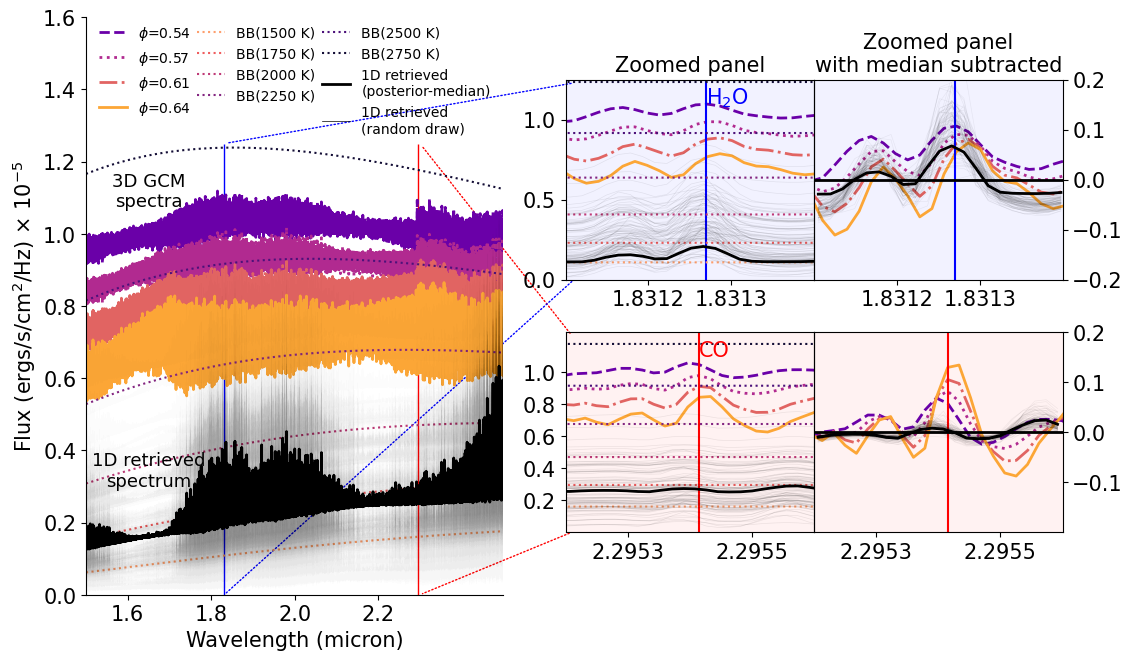

In [6]:
cmap = colormaps['plasma']
c_list = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]


fig = plt.figure(figsize=(1.68*7.5,7.5))
gs = fig.add_gridspec(4, 4,wspace=0., height_ratios=[0.05,1,1,0.05], width_ratios=[1.68,0.25,1.,1], hspace=0.5)
ax1 = fig.add_subplot(gs[0:4,0])
ax2 = fig.add_subplot(gs[1:2,2])
ax3 = fig.add_subplot(gs[1:2,3])
ax4 = fig.add_subplot(gs[2:3,2])
ax5 = fig.add_subplot(gs[2:3,3])

files = os.listdir(os.path.join(dirin_models, dirname_model))

for n, fname_model in enumerate(files):
    f = os.path.join(dirin_models, dirname_model, fname_model)
    ph = HayleyBeltzModel.get_phase(f)
    wl, flux = HayleyBeltzModel.load_spectrum(f)
    if n == 0:
        nph = len(files)
        nx = len(wl)
        ph_all = np.zeros(nph)
        flux_all = np.zeros(shape=(nx, nph))
    flux_all[:,n] = flux
    ph_all[n] = ph
wl_all = np.copy(wl)
ph_all_sorted = np.argsort(ph_all)
ph_all = ph_all[ph_all_sorted][::2]
flux_all = flux_all[:,ph_all_sorted][:,::2]

ax1.set_ylabel(r'Flux (ergs/s/cm$^2$/Hz) $\times$ 10$^{-5}$', size=13)

interp_spectrum_in_ph = SpectrumPhaseInterpolator(wl_all, flux_all, ph_all)

phases = np.linspace(0.54, 0.64, 4)
files = np.sort([f for f in os.listdir(os.path.join(dirin_models, dirname_model)) if f.startswith('Spec_1')])
ls_list = ['--', ':', '-.', '-']
c_list=['k', 'k', 'k', 'k']
c_list = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]
for ph, ls, c in zip(phases, ls_list, c_list):
    wl, flux = interp_spectrum_in_ph(wls=wl_all, ph=ph)
    nwl, nx = len(wl), len(flux)
    ax1.plot(wl,flux/1e-5, label=r'$\phi$=' + f'{float(ph):.2f}', ls=ls, color=c, lw=2)
    ax4.plot(wl,flux/1e-5, label=r'$\phi$=' + f'{float(ph):.2f}', ls=ls, color=c, lw=2)
    wl_range = np.logical_and(wl >= 2.2943, wl <= 2955)
    ax5.plot(wl,flux/1e-5 - np.median(flux[wl_range]/1e-5), label=r'$\phi$=' + f'{float(ph):.2f}', ls=ls, color=c, lw=2)
    ax2.plot(wl,flux/1e-5, label=r'$\phi$=' + f'{float(ph):.2f}', ls=ls, color=c, lw=2)
    ax3.plot(wl,flux/1e-5 - np.median(flux[wl_range]/1e-5), label=r'$\phi$=' + f'{float(ph):.2f}', ls=ls, color=c, lw=2)

ax1.set_xlabel('Wavelength (micron)', size=15)
ax1.set_ylabel(r'Flux (ergs/s/cm$^2$/Hz) $\times$ 10$^{-5}$', size=15)

ax1.set_xlabel('Wavelength (micron)', size=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(1.5,2.5)
ax1.set_xticks([1.6, 1.8, 2, 2.2])

colors=['k', 'blue', 'indigo','red']

lambda_min = 2.2952
lambda_max = 2.2956


lambda_min_2 = 1.8311
lambda_max_2  = 1.8314

ax4.set_xlim(lambda_min,lambda_max)
ax1.fill_betweenx(y=[-10,1.25],x1=lambda_min,x2=lambda_max, color='r')
ax1.fill_betweenx(y=[-10,1.25],x1=lambda_min_2,x2=lambda_max_2, color='b')

ax1.set_ylim(0.4,1.25)
ax4.set_ylim(0.4,1.25)

ax2.set_xlim(lambda_min_2,lambda_max_2)
ax2.set_ylim(0.0,1.25)

continuum_wl=2.295197
CO_wl = 2.2954152
H2O_wl = 2.294487
H2O_wl = 1.83127

ax4.axvline(CO_wl, color='r')
ax4.axvline(continuum_wl, color='grey')
ax2.axvline(H2O_wl, color='b')
ax3.axvline(H2O_wl, color='b')

ax4.annotate(r'CO', xy=(CO_wl, 1.1), color='r', fontsize=15)
ax4.annotate(r'continuum', xy=(continuum_wl, 1.195), color='grey', fontsize=15)
ax2.annotate(r'H$_2$O', xy=(H2O_wl, 1.1), color='b', fontsize=15)

ax5.set_xlim(lambda_min,lambda_max)
ax5.fill_betweenx(y=[-10,2],x1=2.309,x2=2.311, color='k')
ax5.set_ylim(-0.2,0.2)

ax3.set_xlim(lambda_min_2,lambda_max_2)
ax3.fill_betweenx(y=[-10,2],x1=2.309,x2=2.311, color='k')
ax3.set_ylim(-0.2,0.2)

ax5.axvline(CO_wl, color='r')
ax5.axvline(continuum_wl, color='grey')
ax5.axvline(H2O_wl, color='b')

ax5.axvline(H2O_wl, color='b')

ax5.annotate(r'CO', xy=(CO_wl, 1.1), color='r', fontsize=15)
ax5.annotate(r'continuum', xy=(continuum_wl, 1.175-0.02), color='grey', fontsize=15)
ax3.annotate(r'H$_2$O', xy=(H2O_wl, 1.1), color='b', fontsize=15)
ax5.axhline(y=0, lw=2, color='k')
ax3.axhline(y=0, lw=2, color='k')
yticks2 = ax5.get_yticks()
yticks2 = ax5.set_yticks(yticks2[1:])

ax2.set_title('Zoomed panel', fontsize=15)
ax3.set_title('Zoomed panel\nwith median subtracted', fontsize=15)


def flux_density_wav2freq(flux_density_wl, wl):
    """All units must be cgs units for this to work."""
    c = 2.998e10 # cm / s
    flux_density_freq = flux_density_wl * ( wl**2 / c )
    return flux_density_freq

T_list = [1500,1750,2000,2250,2500,2750]
cmap = colormaps['magma_r']
c_list = [cmap(n) for n in np.linspace(0.2,0.9,len(T_list))]

for T,c in zip(T_list, c_list):
    bbf = models.BlackBody(temperature=T*u.K)
    bb = bbf(wl*u.m*1e-6) * np.pi * u.sr # factor pi convert BB intensity to BB flux
    ax1.plot(wl, bb/1e-5, label=f'BB({T} K)', color=c, ls=':')
    ax4.plot(wl, bb/1e-5, label=f'Black Body T={T} K', color=c, ls=':')
    ax2.plot(wl, bb/1e-5, label=f'Black Body T={T} K', color=c, ls=':')

vbroad =6.6

wno_all = np.load('../data/fms/xrand_wno_all.npy')
flux_all = np.load('../data/fms/xrand_flux_all.npy')
xrand = np.loadtxt('../data/fms/xrand_3D.npy')
dvsys, dKp = np.median(xrand[:,-2]), np.median(xrand[:,-3])

model_list = ['../data/fms/fm_3D.pic'] #,'./spectra/fm_dopon_H2O_dissociated.pic']
c_list = ['k'] #, 'b']
for model, c in zip(model_list, c_list):
    RV = dvsys + dKp * np.sin(0.59 * 2. * np.pi)
    dl_l = RV / 2.99792e5
    wn, flux = pickle.load(open(model, 'rb'))

    wl = 1e4/wn
    flux = np.median(flux_all, axis=0) #flux_density_wav2freq(flux*(1e2)**-3, wl*1e-4) * 1e7
    flux = flux_density_wav2freq(flux*(1e2)**-3, wl*1e-4) * 1e7

    wShift = wl * (1.0 - dl_l)
    flux = rot_int_cmj(w=wl[::-1], s=flux[::-1], vsini=vbroad)[::-1]
    cs_p = interpolate.splrep(wl[::-1], flux[::-1])
    flux = interpolate.splev(wShift, cs_p, der=0)

    ax1.plot(wl, flux/1e-5, color=c, lw=2,label='1D retrieved\n(posterior-median)')
    ax1.set_ylim(0,1.6)

    ax4.plot(wl, flux/1e-5, color=c, lw=2)
    ax4.set_ylim(0,1.25)

    bbf = models.BlackBody(temperature=1500*u.K)
    bb = bbf(wl*u.m*1e-6) * np.pi * u.sr # factor pi convert BB intensity to BB flux

    wl_range = np.logical_and(wl >= lambda_min, wl <= lambda_max)
    ax5.plot(wl[wl_range], (flux[wl_range]-np.mean(flux[wl_range]))/1e-5, color=c, lw=2)

    wl_range = np.logical_and(wl >= lambda_min, wl <= lambda_max)

for model, c in zip(model_list, c_list):
    wn, flux = pickle.load(open(model, 'rb'))
    wl = 1e4/wn
    flux = flux_density_wav2freq(flux*(1e2)**-3, wl*1e-4) * 1e7
    
    wShift = wl * (1.0 - dl_l)
    flux = rot_int_cmj(w=wl[::-1], s=flux[::-1], vsini=vbroad)[::-1]
    cs_p = interpolate.splrep(wl[::-1], flux[::-1])
    flux = interpolate.splev(wShift, cs_p, der=0)
    

    ax2.plot(wl, flux/1e-5, color=c, lw=2)
    ax2.set_ylim(0,1.25)
    
    bbf = models.BlackBody(temperature=1500*u.K)
    bb = bbf(wl*u.m*1e-6) * np.pi * u.sr # factor pi convert BB intensity to BB flux
    
    wl_range = np.logical_and(wl >= lambda_min_2, wl <= lambda_max_2)
    ax3.plot(wl[wl_range], (flux[wl_range]-np.mean(flux[wl_range]))/1e-5, color=c, lw=2)
    
    wl_range = np.logical_and(wl >= lambda_min_2, wl <= lambda_max_2)

ax1.annotate('', xy=(np.round(lambda_min,2), 0), xytext=(lambda_min+1e-5, 0), xycoords=ax1.transData, 
         textcoords=ax4.transData, 
         arrowprops=dict(color='red', arrowstyle='-', ls=':', clip_on=False), zorder=-1)
ax1.annotate('', xy=(np.round(lambda_min,2), 1.25), xytext=(lambda_min+1e-5, 1.23), xycoords=ax1.transData, 
         textcoords=ax4.transData, 
         arrowprops=dict(color='red', arrowstyle='-', ls=':', clip_on=False), zorder=-1)

ax1.annotate('', xy=(lambda_min_2, 0), xytext=(lambda_min_2+1e-5, 0), xycoords=ax1.transData, 
         textcoords=ax2.transData, 
         arrowprops=dict(color='blue', arrowstyle='-', ls=':', clip_on=False), zorder=-1)
ax1.annotate('', xy=(lambda_min_2, 1.25), xytext=(lambda_min_2+1e-5, 1.23), xycoords=ax1.transData, 
         textcoords=ax2.transData, 
         arrowprops=dict(color='blue', arrowstyle='-', ls=':', clip_on=False), zorder=-1)

ax1.annotate('1D retrieved\nspectrum', color='k', fontsize=13, xy=(1.65,0.3), ha='center')
ax1.annotate('3D GCM\nspectra', color='k', fontsize=13, xy=(1.65,1.075), ha='center')

ax3.yaxis.tick_right()
ax5.yaxis.tick_right()
ax5.set_xticks([lambda_min+0.0001,lambda_max-0.0001])
ax4.set_xticks([lambda_min+0.0001,lambda_max-0.0001])
ax5.set_xticklabels([lambda_min+0.0001,np.round(lambda_max-0.0001,4)])
ax4.set_xticklabels([lambda_min+0.0001,np.round(lambda_max-0.0001,4)])

ax2.set_xticks([lambda_min_2+0.0001,lambda_max_2-0.0001])
ax3.set_xticks([lambda_min_2+0.0001,lambda_max_2-0.0001])
ax2.set_xticklabels([lambda_min_2+0.0001,np.round(lambda_max_2-0.0001,4)])
ax3.set_xticklabels([lambda_min_2+0.0001,np.round(lambda_max_2-0.0001,4)])

ax4.set_yticks([0.2,0.4,0.6,0.8,1.0])

ax2.patch.set_facecolor('blue')
ax2.patch.set_alpha(0.05)
ax3.patch.set_facecolor('blue')
ax3.patch.set_alpha(0.05)

ax4.patch.set_facecolor('red')
ax4.patch.set_alpha(0.05)
ax5.patch.set_facecolor('red')
ax5.patch.set_alpha(0.05)

for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

nsamples = 100
lw_rand = 0.5
xrand = np.loadtxt('../data/fms/xrand_3D.npy')

ax1.plot(wl, flux/1e-5 - 1e99, color=c, lw=lw_rand, alpha=1, label='1D retrieved\n(random draw)')
for i, (wn, flux, xx) in enumerate(zip(wno_all[:nsamples,:], flux_all[:nsamples,:], xrand[:nsamples, :])):
    _, _, _, _, _, _, _, _, dKp, dvsys, vbroad = xx
    
    RV = dvsys + dKp * np.sin(0.59*2*np.pi)
    # print('average RV = {} km/s'.format(RV))
    dl_l = RV / 2.99792e5

    wl = 1e4/wn
    flux = flux_density_wav2freq(flux*(1e2)**-3, wl*1e-4) * 1e7

    wShift = wl * (1.0 - dl_l)
    flux = rot_int_cmj(w=wl[::-1], s=flux[::-1], vsini=vbroad)[::-1]
    cs_p = interpolate.splrep(wl[::-1], flux[::-1])
    flux = interpolate.splev(wShift, cs_p, der=0)

    ax1.plot(wl, flux/1e-5, color=c, lw=lw_rand, alpha=0.01)
    ax4.plot(wl, flux/1e-5, color=c, lw=lw_rand, alpha=0.075)
    ax2.plot(wl, flux/1e-5, color=c, lw=lw_rand, alpha=0.075)

    bbf = models.BlackBody(temperature=1500*u.K)
    bb = bbf(wl*u.m*1e-6) * np.pi * u.sr # factor pi convert BB intensity to BB flux

    wl_range = np.logical_and(wl >= lambda_min, wl <= lambda_max)
    ax5.plot(wl[wl_range], (flux[wl_range]-np.mean(flux[wl_range]))/1e-5, color=c, lw=lw_rand, alpha=0.05)
    wl_range = np.logical_and(wl >= lambda_min_2, wl <= lambda_max_2)
    ax3.plot(wl[wl_range], (flux[wl_range]-np.mean(flux[wl_range]))/1e-5, color=c, lw=lw_rand, alpha=0.05)

ax1.legend(loc=9, ncol=3, fontsize=10, borderpad=0, framealpha=0, columnspacing=0.5)

plt.savefig('../figures/Fig8_1D_spectrum_versus_3D_spectra.png', dpi=200, bbox_inches='tight')
plt.savefig('../figures/Fig8_1D_spectrum_versus_3D_spectra.pdf',bbox_inches='tight')

plt.show()